In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import time

import pennylane as qml
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel

import sys
sys.path.append("../")
from src.utils import plot_dataset, plot_predicted_result, plot_decisionon_boundaries, plot_metrics
from src.feature_map import xx_feature_map, zz_feature_map, angle_feature_map, h_angle_feature_map
from src.kernel import compute_kernel, kernel, evaluate_kernel
from src.schema import KernelParams, Dataset

In [2]:
RANDOM_STATE = 42
DATASET_SIZE = 2000
DATASET_PATH = "../data/datasets/pima_indians_diabetes/diabetes.csv"
SAVE_IMG_DIRC = "../data/images/diabetes/zz_feature_map_8qubit/"

feature_map_list = [xx_feature_map, zz_feature_map, angle_feature_map, h_angle_feature_map]
FEATURE_MAP = feature_map_list[1]

PCA_DIM = None

# Seeting of Quantum Device
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

### 1. Load Pima Indians Diabetes Database

In [3]:
dataset_df = pd.read_csv(DATASET_PATH)
print(f"Dataset shape: {dataset_df.shape}")
dataset_df.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
dataset_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


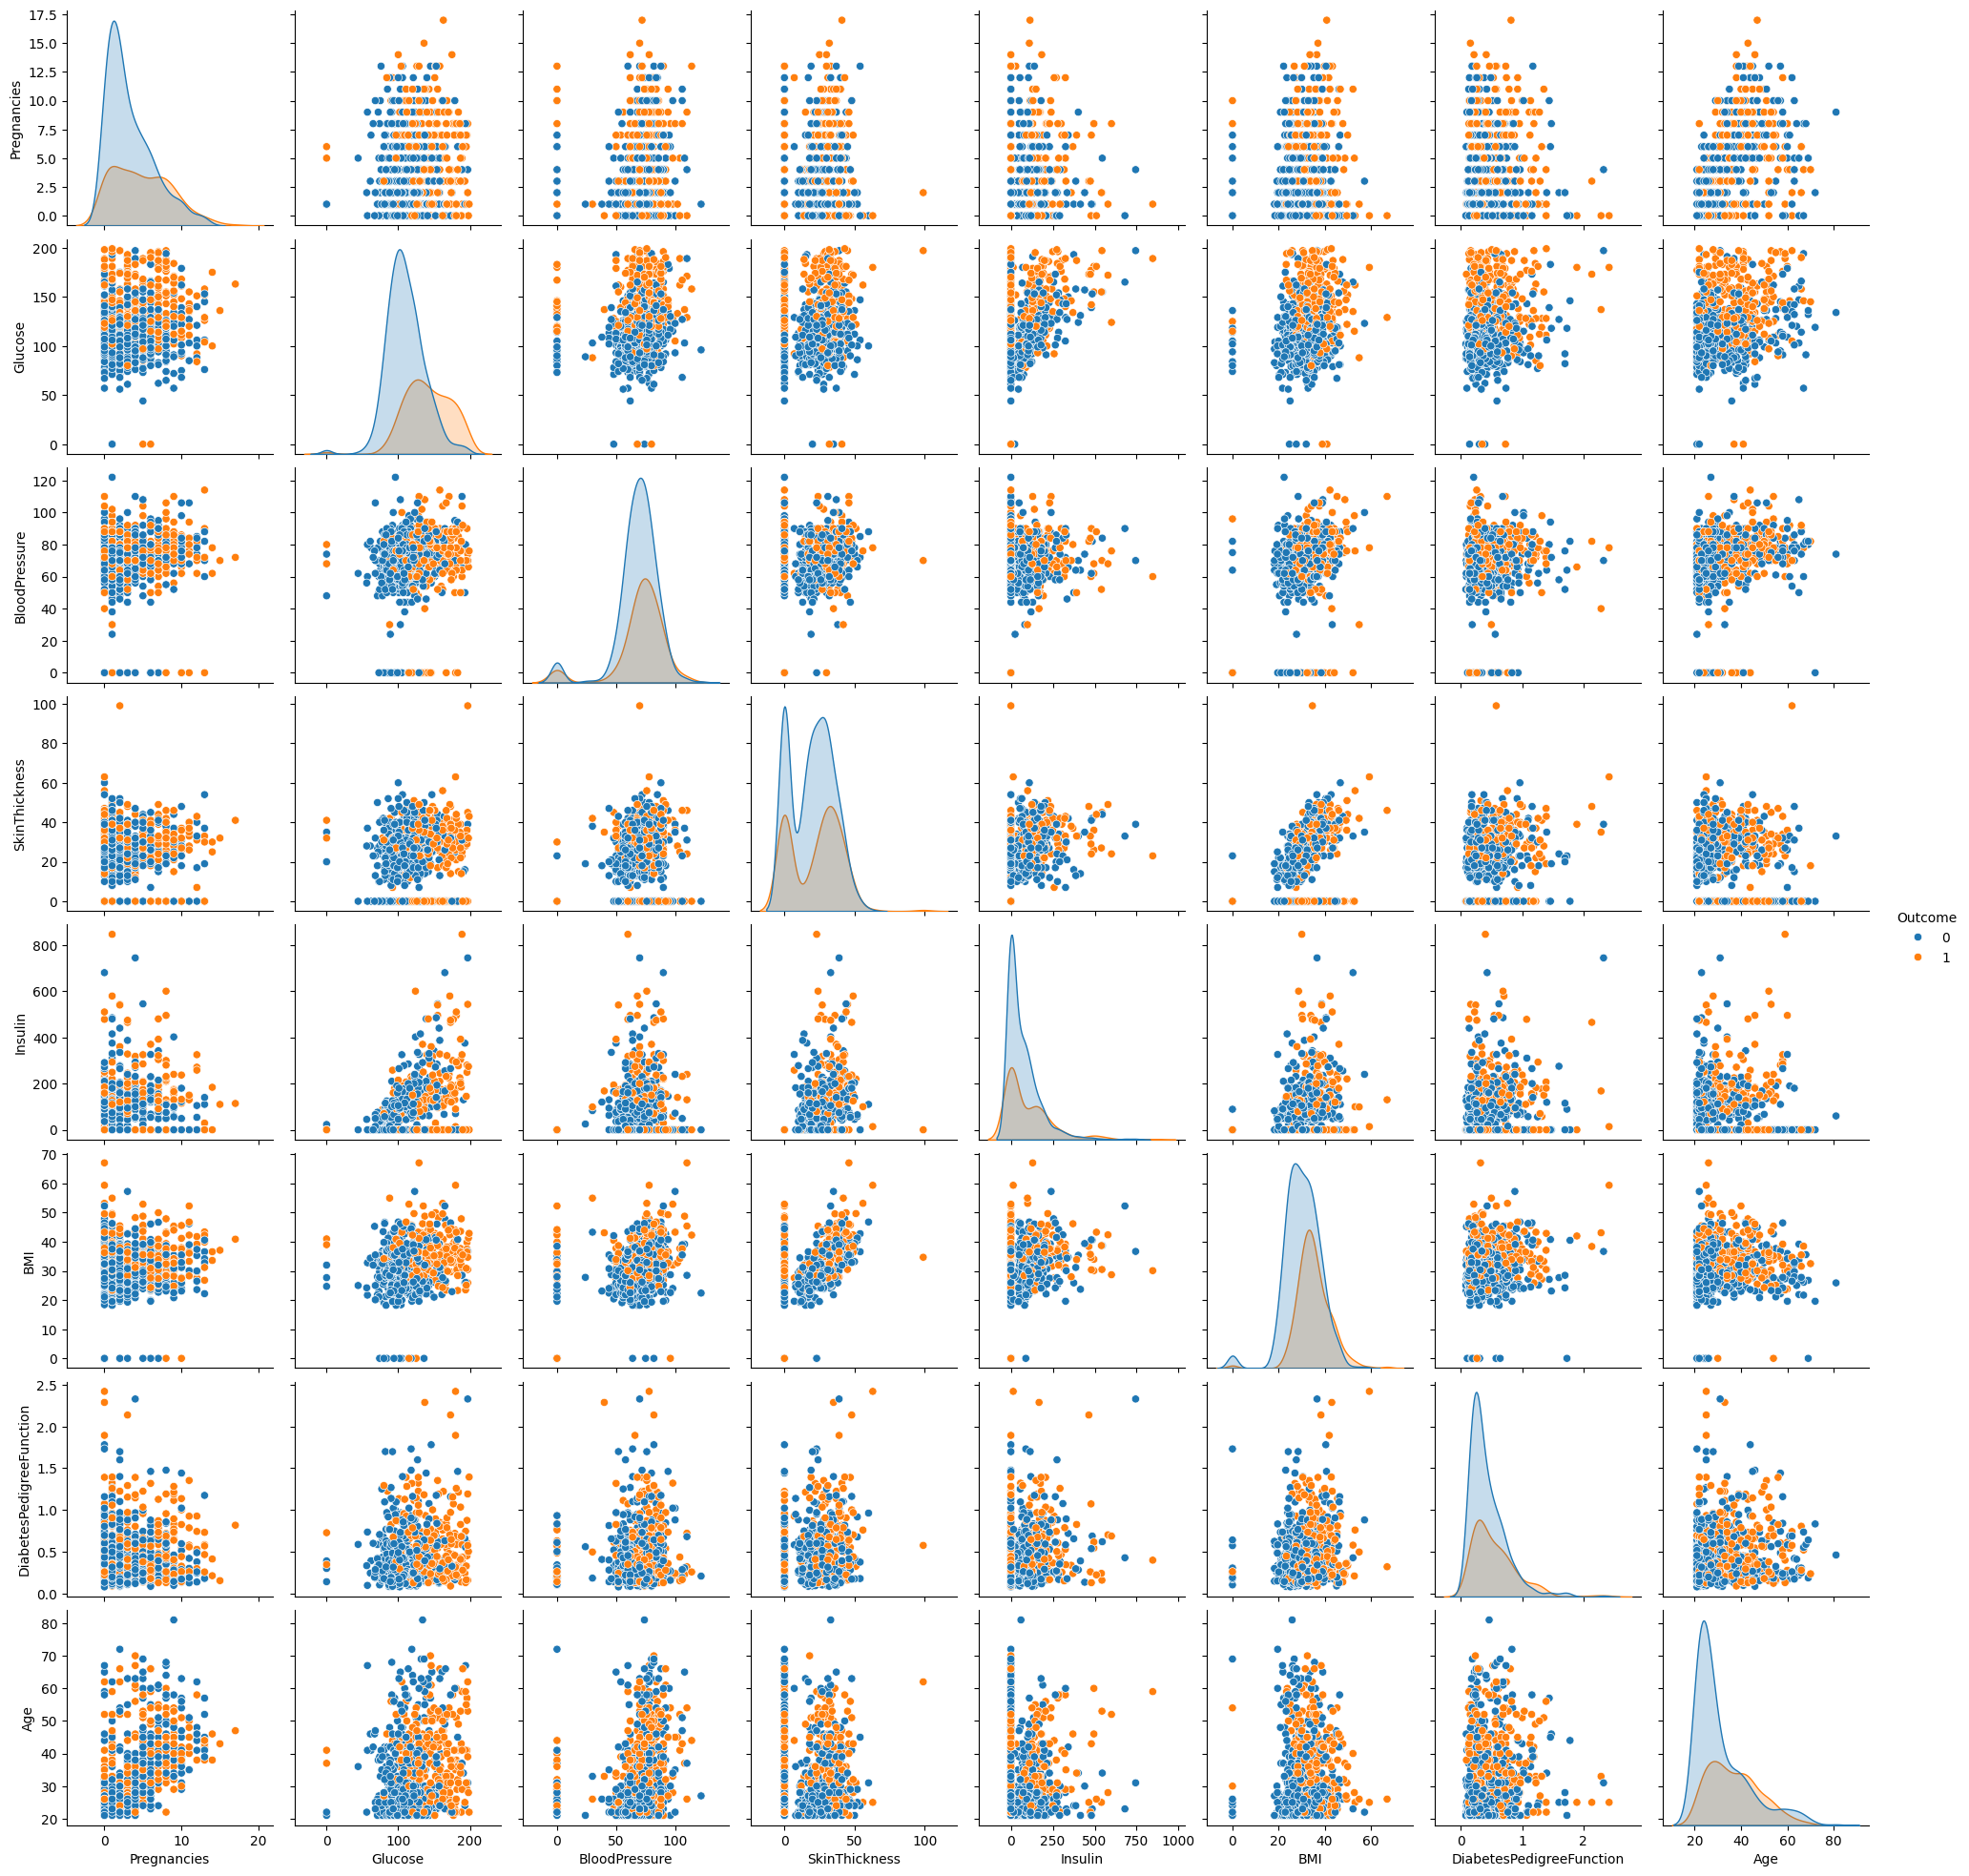

In [5]:
sns.pairplot(dataset_df, hue="Outcome")
plt.show()

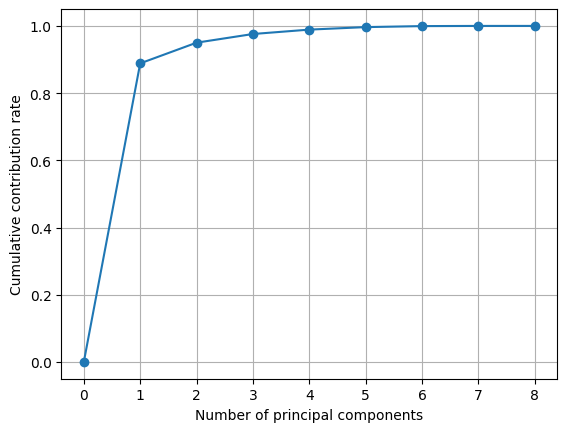

In [6]:
feature_df = dataset_df.drop("Outcome", axis=1)
pca = PCA()
pca.fit(feature_df)
# pd.DataFrame(pca.explained_variance_ratio_, index=["PC_{}".format(x + 1) for x in range(len(feature_df.columns))])

plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

### 2. Format Dataset

In [7]:
target_col = "Outcome"
feature_cols = list(dataset_df.columns)
feature_cols.remove(target_col)

X = dataset_df[feature_cols].to_numpy()[:DATASET_SIZE]
y = dataset_df[target_col].to_numpy()[:DATASET_SIZE]
y = 2 * (y - 0.5)  # convert label to -1, 1
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Splitting dataset
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)
print(f"Trian Shape: {x_train.shape}")
print(f"Test Shape: {x_test.shape}")

# scaling dataset
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
print(f"Scaled Train Shape: {x_train_scaled.shape}")
print(f"Scaled Test Shape: {x_test_scaled.shape}")

# PCA
if PCA_DIM is not None:
    pca = PCA(n_components=PCA_DIM)
    pca.fit(x_train_scaled)
    x_train_scaled = pca.transform(x_train_scaled)
    x_test_scaled = pca.transform(x_test_scaled)

    print(f"PCA train shape: {x_train_scaled.shape}")
    print(f"PCA test shape: {x_test_scaled.shape}")

minmax_scaler = MinMaxScaler(feature_range=(0, 2*np.pi))
minmax_scaler = minmax_scaler.fit(x_train_scaled)
x_train_scaled = minmax_scaler.transform(x_train_scaled)
x_test_scaled = minmax_scaler.transform(x_test_scaled)
print(f"MinMax Scaled Train Shape: {x_train_scaled.shape}")
print(f"MinMax Scaled Test Shape: {x_test_scaled.shape}")

X shape: (768, 8), y shape: (768,)
Trian Shape: (576, 8)
Test Shape: (192, 8)
Scaled Train Shape: (576, 8)
Scaled Test Shape: (192, 8)
MinMax Scaled Train Shape: (576, 8)
MinMax Scaled Test Shape: (192, 8)


In [9]:
dataset = Dataset(
    x_train=x_train_scaled,
    x_test=x_test_scaled,
    y_train=y_train,
    y_test=y_test,
    feature_cols=feature_cols,
    # feature_cols=[f"pc_{i+1}" for i in range(PCA_DIM)],
    target_col=target_col)

### 3. Base Line (Classical SVM)

In [76]:
classic_model = SVC(kernel='rbf', random_state=RANDOM_STATE)
classic_model.fit(dataset.x_train, dataset.y_train)

y_pred = classic_model.predict(dataset.x_test)
accuracy = accuracy_score(dataset.y_test, y_pred)
precision = precision_score(dataset.y_test, y_pred)
recall = recall_score(dataset.y_test, y_pred)
f1 = f1_score(dataset.y_test, y_pred)
# report = classification_report(dataset.y_test, y_pred)
# conf_matrix = confusion_matrix(dataset.y_test, y_pred)

print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1 Score:", round(f1, 2))
# print("\nClassification Report:\n", report)
# print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.58
Precision: 0.78
Recall: 0.27
F1 Score: 0.4


In [77]:
gamma = 1.0 / dataset.x_train.shape[1]
K = rbf_kernel(dataset.x_train, gamma=gamma)

# ターゲット行列の計算
T = np.outer(dataset.y_train, dataset.y_train)

# フロベニウス内積の計算
def frobenius_inner_product(A, B):
    return np.sum(A * B)

# フロベニウスノルムの計算
def frobenius_norm(A):
    return np.sqrt(np.sum(A * A))

# ターゲットアライメントの計算
alignment = frobenius_inner_product(K, T) / (frobenius_norm(K) * frobenius_norm(T))

print(f"Target Alignment: {alignment}")

Target Alignment: 0.24113044113589172


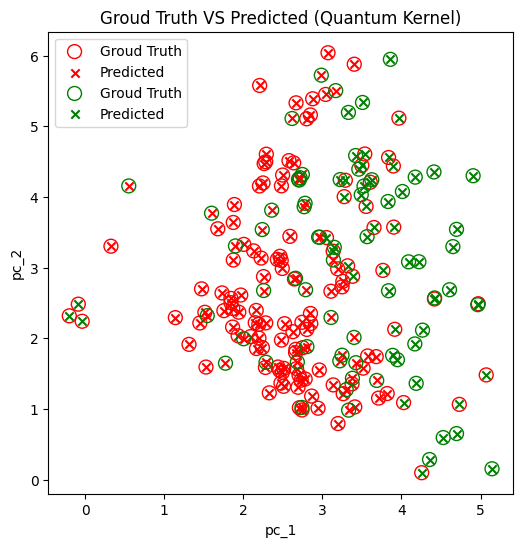

In [70]:
plot_predicted_result(
    dataset, 
    y_pred,
    axis=[0, 1],
    save_path=None
    # save_path=f"{SAVE_IMG_DIRC}/reps{kernel_params.reps}_predict.png"
    )

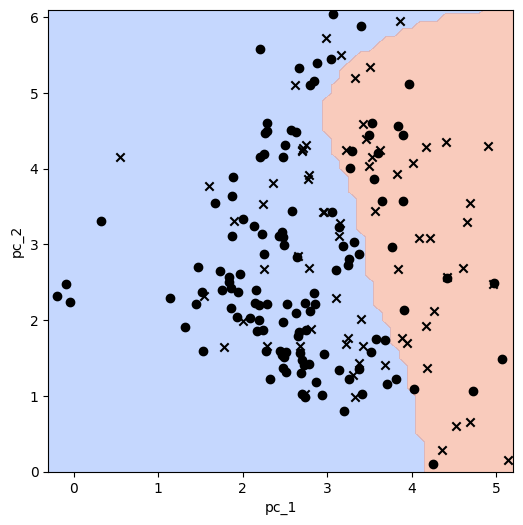

In [71]:
plot_decisionon_boundaries(
    classic_model, 
    dataset,
    None,
    step_size=0.1, 
    save_path=None
    # save_path=f"{SAVE_IMG_DIRC}/reps{kernel_params.reps}_boundary.png"
)

### 4. QSVM 

In [10]:
@qml.qnode(dev)
def kernel_with_qnode(x1, x2, kernel_params):
    return kernel(x1, x2, kernel_params)

In [140]:
# def feature_map(x, n_qubits, rotaion_axis=["X"], reps=1):
#     for _ in range(reps):
#         qml.AmplitudeEmbedding(x, wires=range(n_qubits), normalize=True, pad_with=0.)
#         for i in range(n_qubits):
#             qml.Hadamard(wires=i)
#         # for ax in rotaion_axis:
#         #     qml.AngleEmbedding(x, wires=range(n_qubits), rotation=ax)
#         for i in range(0, n_qubits - 1):
#             qml.CNOT(wires=[i, i + 1])

def feature_map(x, n_qubits, reps=3):
    for _ in range(reps):
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
            qml.RZ(x[i], wires=i)

        for i in range(0, n_qubits - 1):
            qml.IsingZZ(2*(np.pi - x[i]) * (np.pi - x[i + 1]), wires=[i, i + 1])

In [147]:
kernel_params = KernelParams(
    n_qubits=n_qubits,
    feature_map=feature_map,
    reps=2,
    kernel=kernel_with_qnode,
    rotaion_axis=None
    # rotaion_axis=["Z"]
)

In [148]:
train_kernel = compute_kernel(dataset.x_train, dataset.x_train, kernel_params)
test_kernel = compute_kernel(dataset.x_test, dataset.x_train, kernel_params)

print(f"Train Kernel Matrix Shape: {train_kernel.shape}")
print(f"Test Kernel Matrix Shape: {test_kernel.shape}")

print(qml.draw(kernel)(dataset.x_train[0], dataset.x_train[1], kernel_params))

100%|██████████| 50/50 [00:07<00:00,  6.95it/s]

Train Kernel Matrix Shape: (150, 150)
Test Kernel Matrix Shape: (50, 150)
0: ──H──RZ(4.32)─╭IsingZZ(-0.38)──H──RZ(4.32)─╭IsingZZ(-0.38)─╭IsingZZ(-0.33)†──RZ(3.05)†──H†
1: ──H──RZ(2.98)─╰IsingZZ(-0.38)──H──RZ(2.98)─╰IsingZZ(-0.38)─╰IsingZZ(-0.33)†──RZ(4.99)†──H†

──╭IsingZZ(-0.33)†──RZ(3.05)†──H†─┤ ╭Probs
──╰IsingZZ(-0.33)†──RZ(4.99)†──H†─┤ ╰Probs


In [149]:
model = SVC(kernel="precomputed")
model.fit(train_kernel, dataset.y_train)

start_time = time.time()
y_pred = model.predict(test_kernel)
end_time = time.time()
pred_time = (end_time - start_time) / test_kernel.shape[0]
print(f"Prediction time: {pred_time:.2f} [s/instance]")

accuracy = accuracy_score(dataset.y_test, y_pred)
precision = precision_score(dataset.y_test, y_pred)
recall = recall_score(dataset.y_test, y_pred)
f1 = f1_score(dataset.y_test, y_pred)
# report = classification_report(dataset.y_test, y_pred)
# conf_matrix = confusion_matrix(dataset.y_test, y_pred)

print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1 Score:", round(f1, 2))
# print("\nClassification Report:\n", report)
# print("\nConfusion Matrix:\n", conf_matrix)

Prediction time: 0.00 [s/instance]
Accuracy: 0.44
Precision: 0.25
Recall: 0.04
F1 Score: 0.07


In [144]:
# _ = evaluate_kernel(dataset.x_train, dataset.y_train, kernel_params)

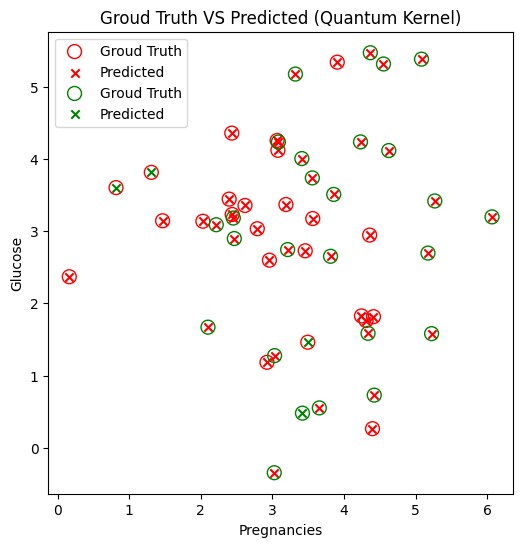

In [150]:
plot_predicted_result(
    dataset, 
    y_pred,
    axis=[0, 1],
    save_path=None
    # save_path=f"{SAVE_IMG_DIRC}/reps{kernel_params.reps}_predict.png"
    )

Calculating Kernel Matrix for 3721 mesh points


100%|██████████| 3721/3721 [08:57<00:00,  6.92it/s]


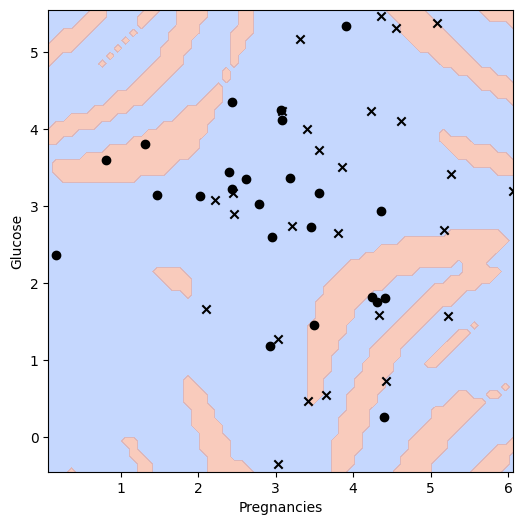

In [152]:
plot_decisionon_boundaries(
    model, 
    dataset,
    kernel_params,
    step_size=0.1, 
    save_path=None
    # save_path=f"{SAVE_IMG_DIRC}/reps{kernel_params.reps}_boundary.png"
)

### 5. Batch Prediction

******************* ['X'] *******************


100%|██████████| 192/192 [00:47<00:00,  4.08it/s]


Accuracy: 0.68
Precision: 0.56
Recall: 0.48
F1 Score: 0.52
Calculating Kernel Matrix for 182 mesh points


100%|██████████| 182/182 [00:44<00:00,  4.07it/s]


Target Kernel Alignment: 0.06
******************* ['Y'] *******************


100%|██████████| 192/192 [00:47<00:00,  4.08it/s]


Accuracy: 0.68
Precision: 0.56
Recall: 0.48
F1 Score: 0.52
Calculating Kernel Matrix for 182 mesh points


100%|██████████| 182/182 [00:46<00:00,  3.90it/s]


Target Kernel Alignment: 0.06
******************* ['Z'] *******************


100%|██████████| 192/192 [00:44<00:00,  4.33it/s]
/Users/kenya/sandbox/quantum-kernel/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.64
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Calculating Kernel Matrix for 182 mesh points


100%|██████████| 182/182 [00:42<00:00,  4.28it/s]


Target Kernel Alignment: -0.00
******************* ['X', 'Y'] *******************


100%|██████████| 192/192 [01:09<00:00,  2.78it/s]


Accuracy: 0.71
Precision: 0.63
Recall: 0.48
F1 Score: 0.55
Calculating Kernel Matrix for 182 mesh points


100%|██████████| 182/182 [01:05<00:00,  2.77it/s]


Target Kernel Alignment: 0.07
******************* ['Y', 'X'] *******************


100%|██████████| 192/192 [01:07<00:00,  2.84it/s]


Accuracy: 0.71
Precision: 0.63
Recall: 0.48
F1 Score: 0.55
Calculating Kernel Matrix for 182 mesh points


100%|██████████| 182/182 [01:04<00:00,  2.83it/s]


Target Kernel Alignment: 0.07
******************* ['X', 'Z'] *******************


100%|██████████| 192/192 [01:03<00:00,  3.01it/s]


Accuracy: 0.63
Precision: 0.48
Recall: 0.29
F1 Score: 0.36
Calculating Kernel Matrix for 182 mesh points


100%|██████████| 182/182 [01:01<00:00,  2.97it/s]


Target Kernel Alignment: 0.01
******************* ['Y', 'Z'] *******************


100%|██████████| 192/192 [01:04<00:00,  2.99it/s]


Accuracy: 0.63
Precision: 0.48
Recall: 0.29
F1 Score: 0.36
Calculating Kernel Matrix for 182 mesh points


100%|██████████| 182/182 [01:01<00:00,  2.96it/s]


Target Kernel Alignment: 0.01


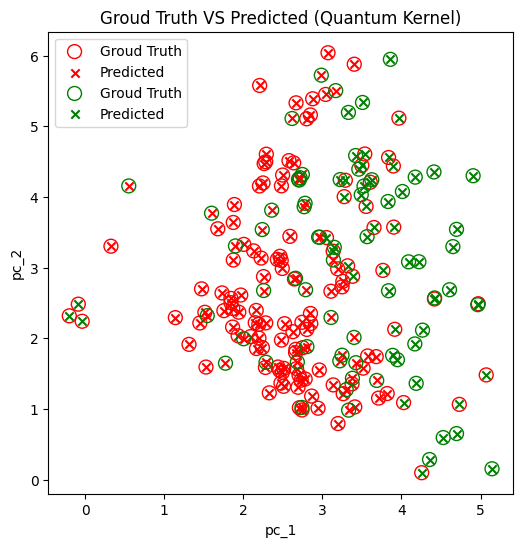

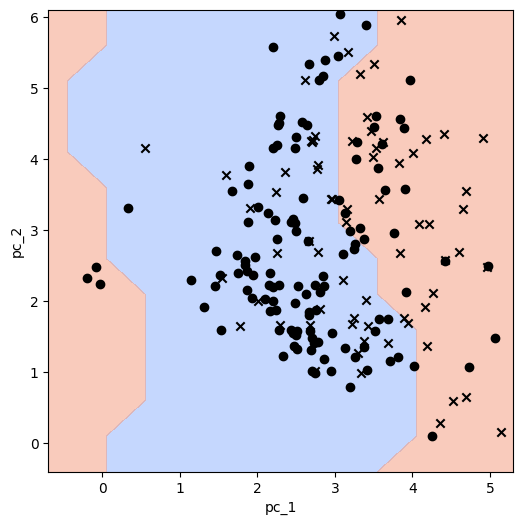

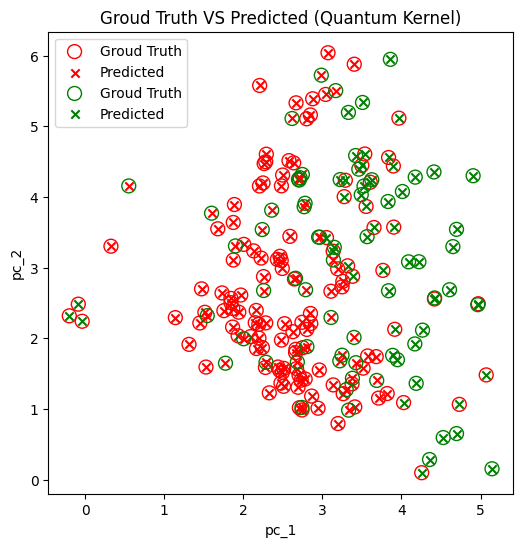

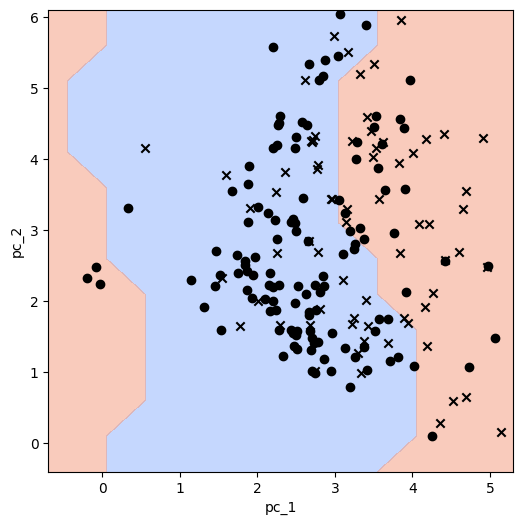

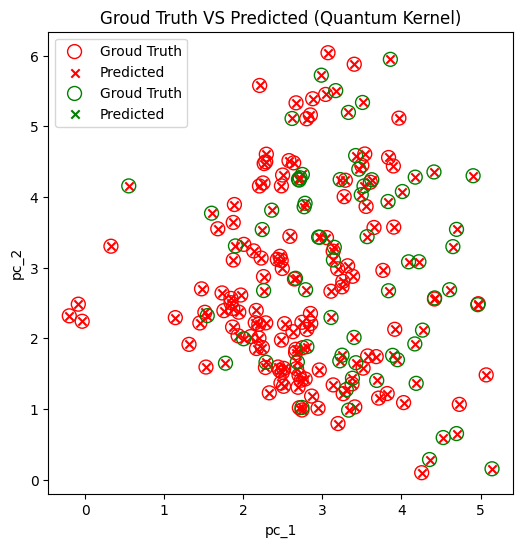

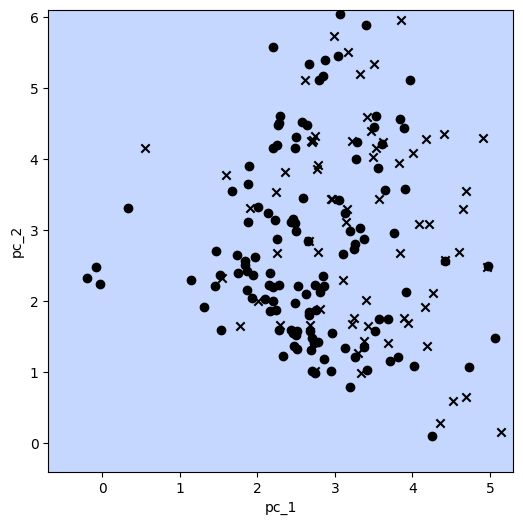

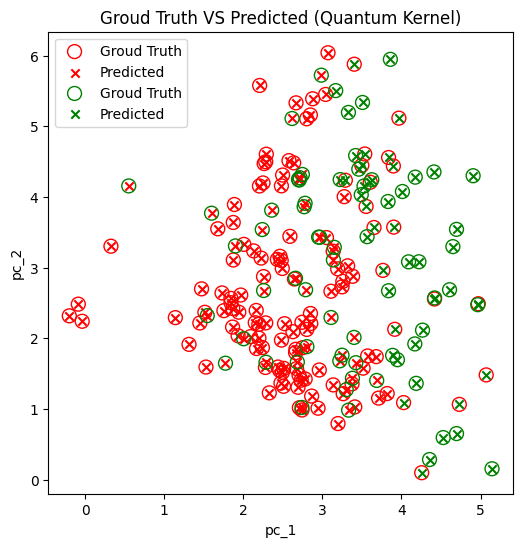

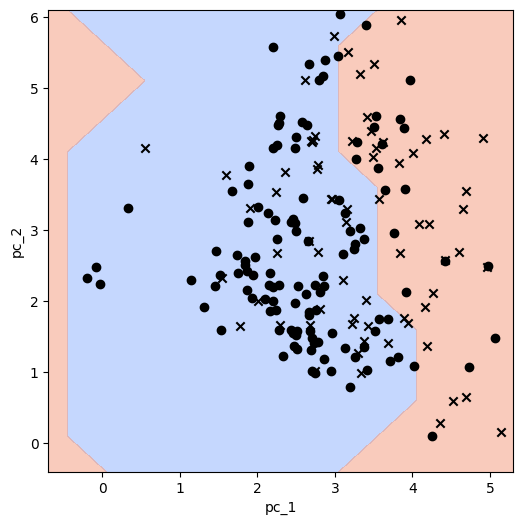

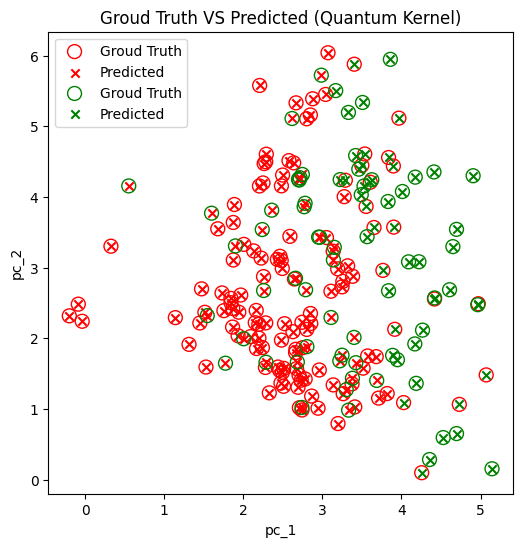

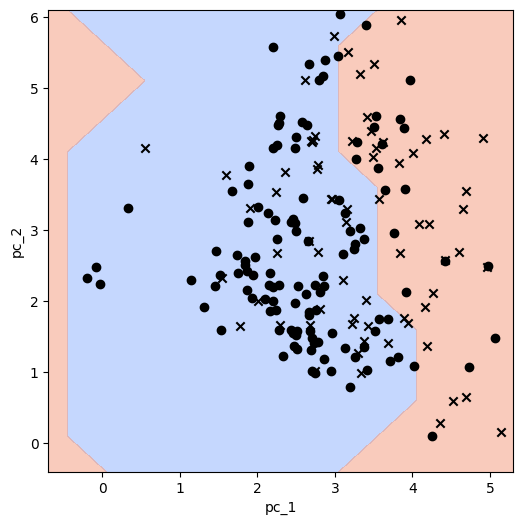

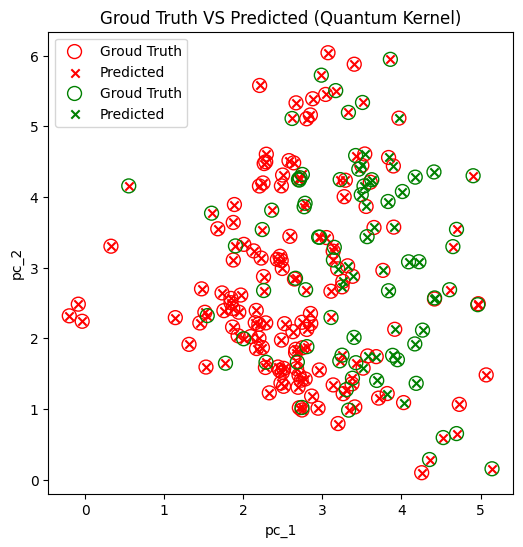

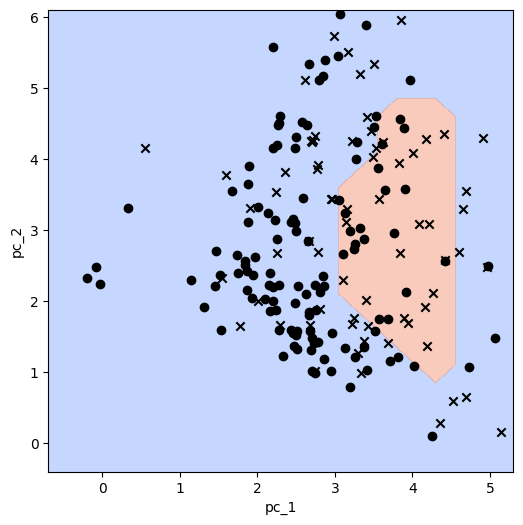

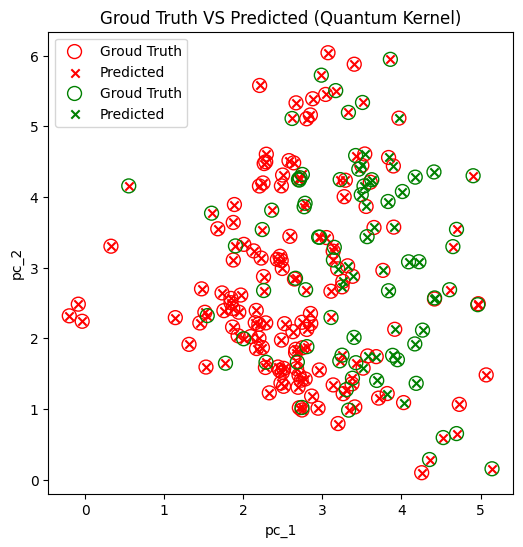

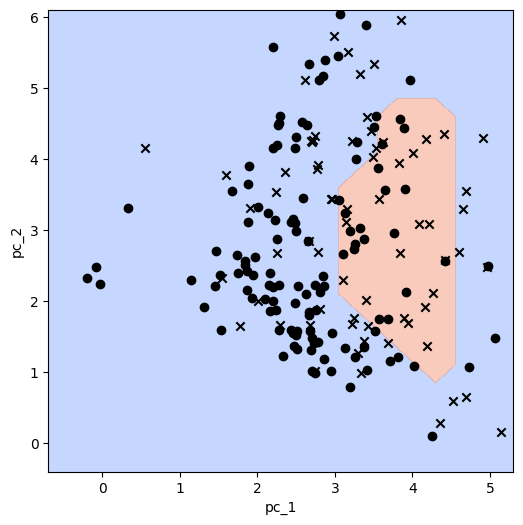

In [54]:
rotation_pattern = [["X"], ["Y"], ["Z"], ["X", "Y"], ["Y", "X"], ["X", "Z"], ["Y", "Z"]]
for rot in rotation_pattern:
    print(f"******************* {rot} *******************")

    kernel_params = KernelParams(
        n_qubits=n_qubits,
        feature_map=FEATURE_MAP,
        reps=1,
        kernel=kernel_with_qnode,
        # rotaion_axis=None
        rotaion_axis=rot
    )

    train_kernel = compute_kernel(dataset.x_train, dataset.x_train, kernel_params)
    test_kernel = compute_kernel(dataset.x_test, dataset.x_train, kernel_params)

    model = SVC(kernel="precomputed")
    model.fit(train_kernel, dataset.y_train)
    y_pred = model.predict(test_kernel)
    accuracy = accuracy_score(dataset.y_test, y_pred)
    precision = precision_score(dataset.y_test, y_pred)
    recall = recall_score(dataset.y_test, y_pred)
    f1 = f1_score(dataset.y_test, y_pred)
    print("Accuracy:", round(accuracy, 2))
    print("Precision:", round(precision, 2))
    print("Recall:", round(recall, 2))
    print("F1 Score:", round(f1, 2))

    rot_name = "-".join(rot)
    plot_predicted_result(
        dataset, 
        y_pred, 
        save_path=f"{SAVE_IMG_DIRC}/rot_{rot_name}_predict.png"
        )
    
    plot_decisionon_boundaries(
        model, 
        dataset,
        kernel_params,
        step_size=0.5, 
        save_path=f"{SAVE_IMG_DIRC}/rot_{rot_name}_boundary.png"
    )

    target_alignment = evaluate_kernel(dataset.x_train, dataset.y_train, kernel_params)

******************* 1 *******************


  0%|          | 0/576 [00:00<?, ?it/s]

100%|██████████| 192/192 [03:55<00:00,  1.23s/it]


Accuracy: 0.61
Precision: 0.27
Recall: 0.04
F1 Score: 0.08
Target Kernel Alignment: 0.04
******************* 2 *******************


100%|██████████| 192/192 [06:56<00:00,  2.17s/it]


Accuracy: 0.65
Precision: 0.56
Recall: 0.07
F1 Score: 0.13
Target Kernel Alignment: 0.05
******************* 3 *******************


100%|██████████| 192/192 [10:12<00:00,  3.19s/it]


Accuracy: 0.63
Precision: 0.42
Recall: 0.07
F1 Score: 0.12
Target Kernel Alignment: 0.04
******************* 4 *******************


100%|██████████| 192/192 [1:25:36<00:00, 26.75s/it]   


Accuracy: 0.64
Precision: 0.43
Recall: 0.04
F1 Score: 0.08


KeyboardInterrupt: 

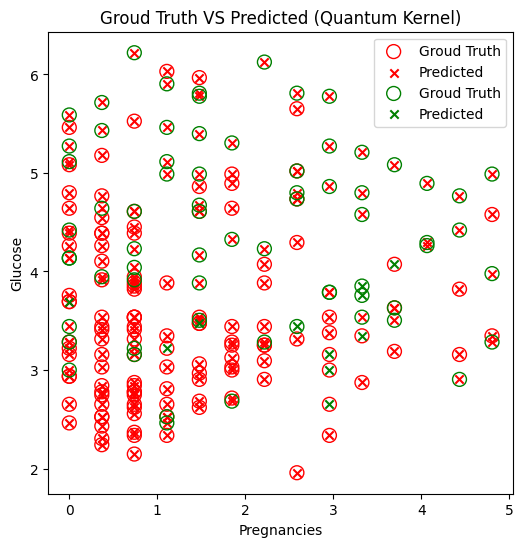

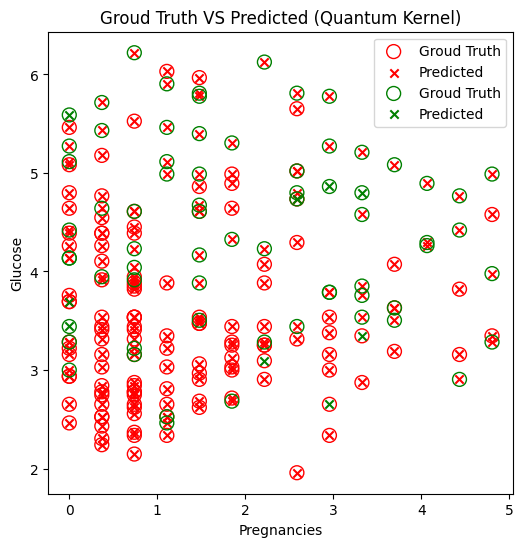

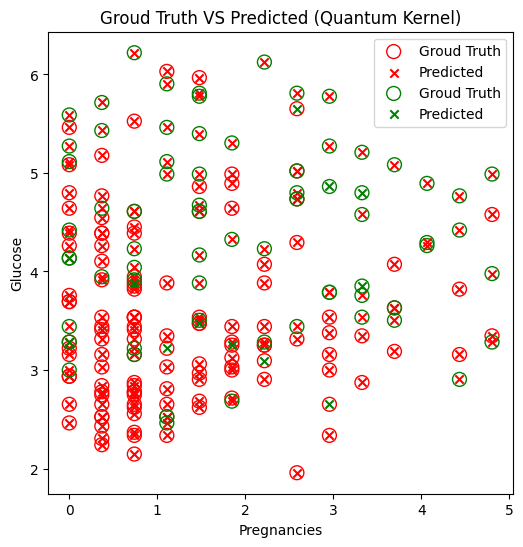

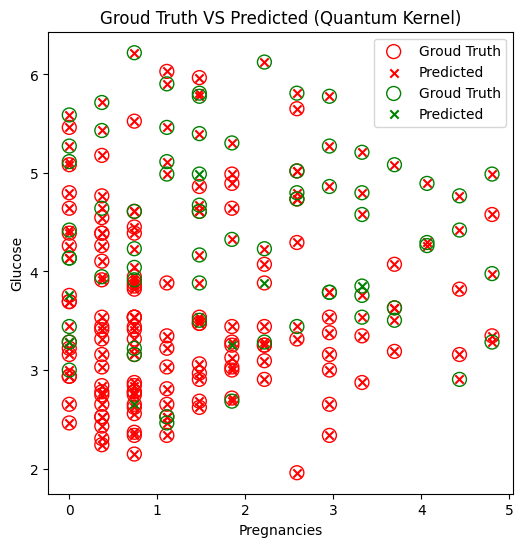

In [15]:
reps_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
target_alignment_list = []

for reps in range(1, 6):
    print(f"******************* {reps} *******************")

    kernel_params = KernelParams(
        n_qubits=n_qubits,
        feature_map=FEATURE_MAP,
        reps=reps,
        kernel=kernel_with_qnode,
        rotaion_axis=None
    )

    train_kernel = compute_kernel(dataset.x_train, dataset.x_train, kernel_params)
    test_kernel = compute_kernel(dataset.x_test, dataset.x_train, kernel_params)

    model = SVC(kernel="precomputed")
    model.fit(train_kernel, dataset.y_train)
    y_pred = model.predict(test_kernel)
    accuracy = accuracy_score(dataset.y_test, y_pred)
    precision = precision_score(dataset.y_test, y_pred)
    recall = recall_score(dataset.y_test, y_pred)
    f1 = f1_score(dataset.y_test, y_pred)
    print("Accuracy:", round(accuracy, 2))
    print("Precision:", round(precision, 2))
    print("Recall:", round(recall, 2))
    print("F1 Score:", round(f1, 2))

    plot_predicted_result(
        dataset, 
        y_pred, 
        save_path=f"{SAVE_IMG_DIRC}/reps{reps}_predict.png"
        )
    
    # plot_decisionon_boundaries(
    #     model, 
    #     dataset,
    #     kernel_params,
    #     step_size=0.5, 
    #     save_path=f"{SAVE_IMG_DIRC}/reps{reps}_boundary.png"
    # )

    target_alignment = evaluate_kernel(dataset.x_train, dataset.y_train, kernel_params)

    reps_list.append(reps)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    target_alignment_list.append(target_alignment)



plot_metrics(
    reps_list, 
    accuracy_list, 
    precision_list,
    recall_list,
    f1_list,
    target_alignment_list, 
    save_path=f"{SAVE_IMG_DIRC}/reps_metrics.png"
    )